In [2]:
import os
import gc
import time
import math
import datetime
from math import log, floor

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad


In [71]:

sales_train_evaluation = pd.read_csv('sales_train_evaluation.csv')
sales_train_evaluation.name = 'sales_train_evaluation'
calendar = pd.read_csv('calendar.csv')
calendar.name = 'calendar'
sell_prices = pd.read_csv('sell_prices.csv')
sell_prices.name = 'sell_prices'
sample_submission = pd.read_csv('sample_submission.csv')

sales_train_validation = pd.read_csv('sales_train_validation.csv')



# Numerical Columns:

Depending on your environment, pandas automatically creates int32, int64, float32 or float64 columns for numeric ones. If you know the min or max value of a column, you can use a subtype which is less memory consuming. You can also use an unsigned subtype if there is no negative value.
Here are the different subtypes you can use:

int8 / uint8 : consumes 1 byte of memory, range between -128/127 or 0/255
bool : consumes 1 byte, true or false
float16 / int16 / uint16: consumes 2 bytes of memory, range between -32768 and 32767 or 0/65535
float32 / int32 / uint32 : consumes 4 bytes of memory, range between -2147483648 and 2147483647
float64 / int64 / uint64: consumes 8 bytes of memory

If one of your column has values between 1 and 10 for example, you will reduce the size of that column from 8 bytes per row to 1 byte, which is more than 85% memory saving on that column!

# Categorical Columns:

Pandas stores categorical columns as objects. One of the reason this storage is not optimal is that it creates a list of pointers to the memory address of each value of your column. For columns with low cardinality (the amount of unique values is lower than 50% of the count of these values), this can be optimized by forcing pandas to use a virtual mapping table where all unique values are mapped via an integer instead of a pointer. This is done using the category datatype.


In [53]:
import numpy as np
import pandas as pd

def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    
    for i, t in enumerate(types):
        col_name = cols[i]
        
        if 'int' in str(t):
            if df[col_name].min() > np.iinfo(np.int8).min and df[col_name].max() < np.iinfo(np.int8).max:
                df[col_name] = df[col_name].astype(np.int8)
            elif df[col_name].min() > np.iinfo(np.int16).min and df[col_name].max() < np.iinfo(np.int16).max:
                df[col_name] = df[col_name].astype(np.int16)
            elif df[col_name].min() > np.iinfo(np.int32).min and df[col_name].max() < np.iinfo(np.int32).max:
                df[col_name] = df[col_name].astype(np.int32)
            else:
                df[col_name] = df[col_name].astype(np.int64)
        
        elif 'float' in str(t):
            if df[col_name].min() > np.finfo(np.float16).min and df[col_name].max() < np.finfo(np.float16).max:
                df[col_name] = df[col_name].astype(np.float16)
            elif df[col_name].min() > np.finfo(np.float32).min and df[col_name].max() < np.finfo(np.float32).max:
                df[col_name] = df[col_name].astype(np.float32)
            else:
                df[col_name] = df[col_name].astype(np.float64)
        
        elif t == object:
            if col_name == 'date':
                df[col_name] = pd.to_datetime(df[col_name], format='%Y-%m-%d', errors='coerce')
            else:
                df[col_name] = df[col_name].astype('category')
    
    return df

sales_train_evaluation = downcast(sales_train_evaluation)
sell_prices = downcast(sell_prices)
calendar = downcast(calendar)
sales_train_validation = downcast(sales_train_validation)


In [73]:
print(sales_train_evaluation.info())
print(sell_prices.info())
print(calendar.info())
print(sales_train_validation.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_n

In [75]:
calendar.head(5)


date  wm_yr_wk    weekday  wday  month  year    d event_name_1  \
0  2011-01-29     11101   Saturday     1      1  2011  d_1          NaN   
1  2011-01-30     11101     Sunday     2      1  2011  d_2          NaN   
2  2011-01-31     11101     Monday     3      1  2011  d_3          NaN   
3  2011-02-01     11101    Tuesday     4      2  2011  d_4          NaN   
4  2011-02-02     11101  Wednesday     5      2  2011  d_5          NaN   

  event_type_1 event_name_2 event_type_2  snap_CA  snap_TX  snap_WI  
0          NaN          NaN          NaN        0        0        0  
1          NaN          NaN          NaN        0        0        0  
2          NaN          NaN          NaN        0        0        0  
3          NaN          NaN          NaN        1        1        0  
4          NaN          NaN          NaN        1        0        1

In [77]:
calendar['d'].unique()


array(['d_1', 'd_2', 'd_3', ..., 'd_1967', 'd_1968', 'd_1969'],
      dtype=object)

In [79]:
sales_train_validation.head(5)


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

In [81]:
sales_train_validation.shape


(30490, 1919)

In [83]:
sales_train_validation['cat_id'].unique()


array(['HOBBIES', 'HOUSEHOLD', 'FOODS'], dtype=object)

In [85]:
sales_train_validation['dept_id'].unique()


array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [87]:
sales_train_validation['state_id'].unique()


array(['CA', 'TX', 'WI'], dtype=object)

In [89]:
sales_train_validation['store_id'].unique()


array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [91]:
sell_prices.head()


store_id        item_id  wm_yr_wk  sell_price
0     CA_1  HOBBIES_1_001     11325        9.58
1     CA_1  HOBBIES_1_001     11326        9.58
2     CA_1  HOBBIES_1_001     11327        8.26
3     CA_1  HOBBIES_1_001     11328        8.26
4     CA_1  HOBBIES_1_001     11329        8.26

In [93]:
sell_prices['item_id'].nunique()


3049

In [95]:
sales_train_validation['store_id'].value_counts()


store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64

In [97]:
sales_train_validation['store_id'].value_counts()


store_id
CA_1    3049
CA_2    3049
CA_3    3049
CA_4    3049
TX_1    3049
TX_2    3049
TX_3    3049
WI_1    3049
WI_2    3049
WI_3    3049
Name: count, dtype: int64

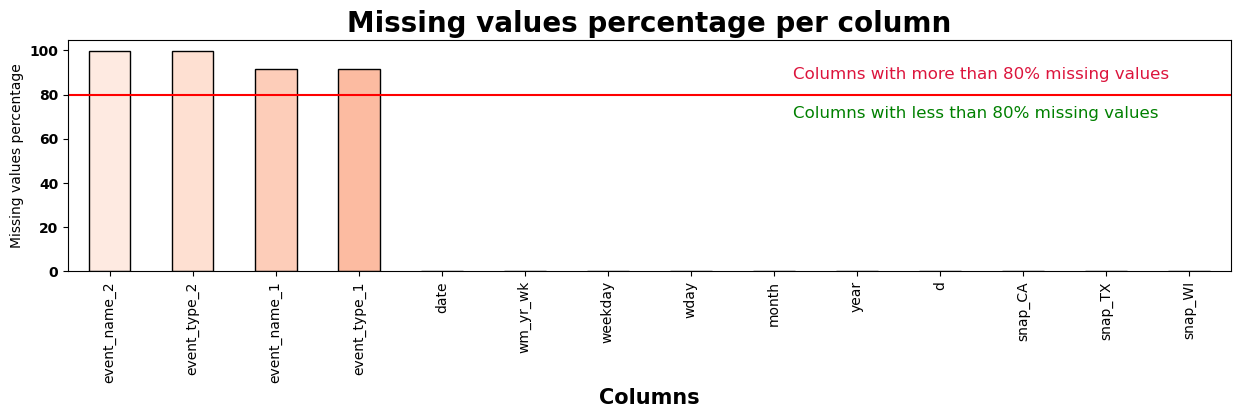

In [99]:
import matplotlib.pyplot as plt 
def msv_1(data, thresh = 20, color = 'black', edgecolor = 'black', height = 3, width = 15):
    
    plt.figure(figsize = (width, height))
    percentage = (data.isnull().mean()) * 100
    percentage.sort_values(ascending = False).plot.bar(color = color, edgecolor = edgecolor)
    plt.axhline(y = thresh, color = 'r', linestyle = '-')
    
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, f'Columns with more than {thresh}% missing values', fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, f'Columns with less than {thresh}% missing values', fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()
msv_1(calendar, 80, color=sns.color_palette('Reds',15))


In [101]:
calendar.drop(["event_name_2", "event_type_2", "event_name_1", "event_type_1"], axis = 1, inplace = True)


In [103]:
calendar.isnull().sum()


date        0
wm_yr_wk    0
weekday     0
wday        0
month       0
year        0
d           0
snap_CA     0
snap_TX     0
snap_WI     0
dtype: int64

## eda

In [108]:
df = sales_train_validation
df.head()


id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_1912  d_1913  
0       1       3       0       1       1  
1       1       0       0       0       0  
2       1       0       1       1       1  
3       0       1       3       7       2  
4       1       2       2       2       4  

[5 rows x 1919 columns]

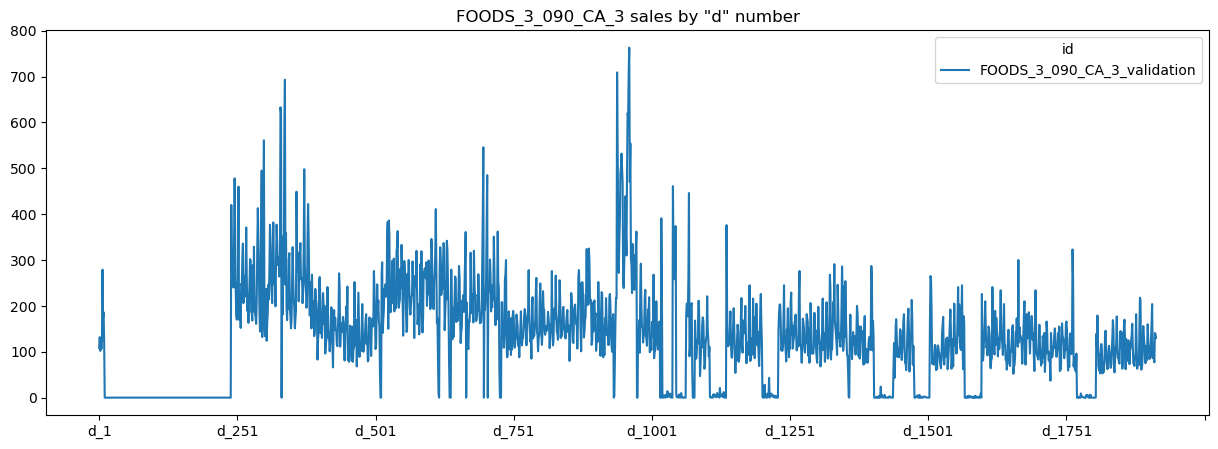

In [110]:
from itertools import cycle
import matplotlib.pyplot as plt

color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

dcols = [c for c in df.columns if 'd_' in c] ## Represents the days(d_1 -> d_1913)

df.loc[df['id'] == 'FOODS_3_090_CA_3_validation'].set_index('id')[dcols].T.plot(
figsize = (15, 5), title='FOODS_3_090_CA_3 sales by "d" number', color = next(color_cycle))
plt.show()


In [112]:
calendar[['d','date','wm_yr_wk', 'weekday', 'wday', 'month', 'year']].head()


d        date  wm_yr_wk    weekday  wday  month  year
0  d_1  2011-01-29     11101   Saturday     1      1  2011
1  d_2  2011-01-30     11101     Sunday     2      1  2011
2  d_3  2011-01-31     11101     Monday     3      1  2011
3  d_4  2011-02-01     11101    Tuesday     4      2  2011
4  d_5  2011-02-02     11101  Wednesday     5      2  2011

In [114]:
example = df.loc[df['id'] == 'FOODS_3_090_CA_3_validation'][dcols].T # Col name will be 8412
example = example.rename(columns={8412:'FOODS_3_090_CA_3'}) # Rename the column to FOODS_3_090_CA_3
example = example.reset_index().rename(columns={'index': 'd'}) # make the index d_1, d_2...d_1913
example = example.merge(calendar, how='left', validate='1:1')
example.head(5)


d  FOODS_3_090_CA_3        date  wm_yr_wk    weekday  wday  month  year  \
0  d_1               108  2011-01-29     11101   Saturday     1      1  2011   
1  d_2               132  2011-01-30     11101     Sunday     2      1  2011   
2  d_3               102  2011-01-31     11101     Monday     3      1  2011   
3  d_4               120  2011-02-01     11101    Tuesday     4      2  2011   
4  d_5               106  2011-02-02     11101  Wednesday     5      2  2011   

   snap_CA  snap_TX  snap_WI  
0        0        0        0  
1        0        0        0  
2        0        0        0  
3        1        1        0  
4        1        0        1

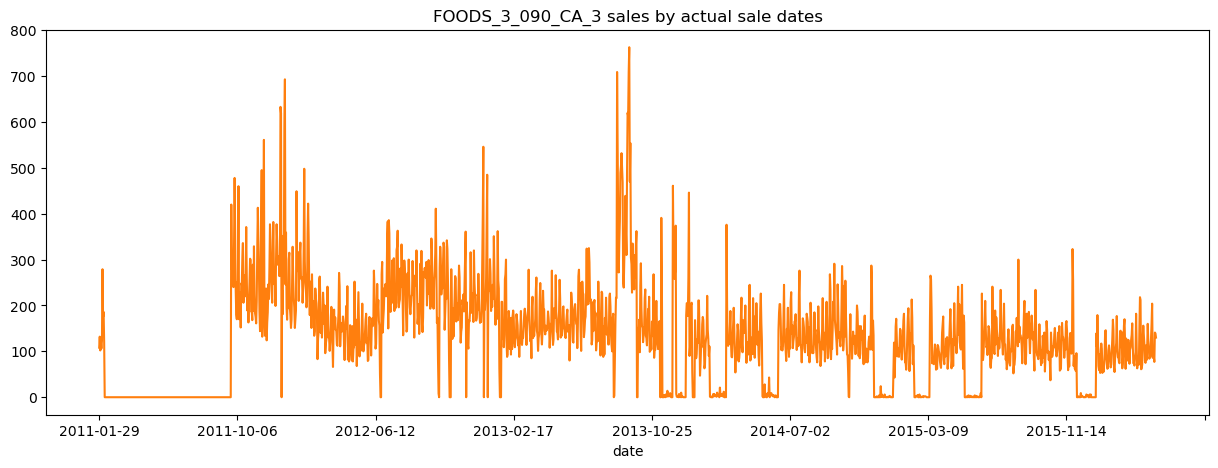

In [116]:
example.set_index('date')['FOODS_3_090_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()


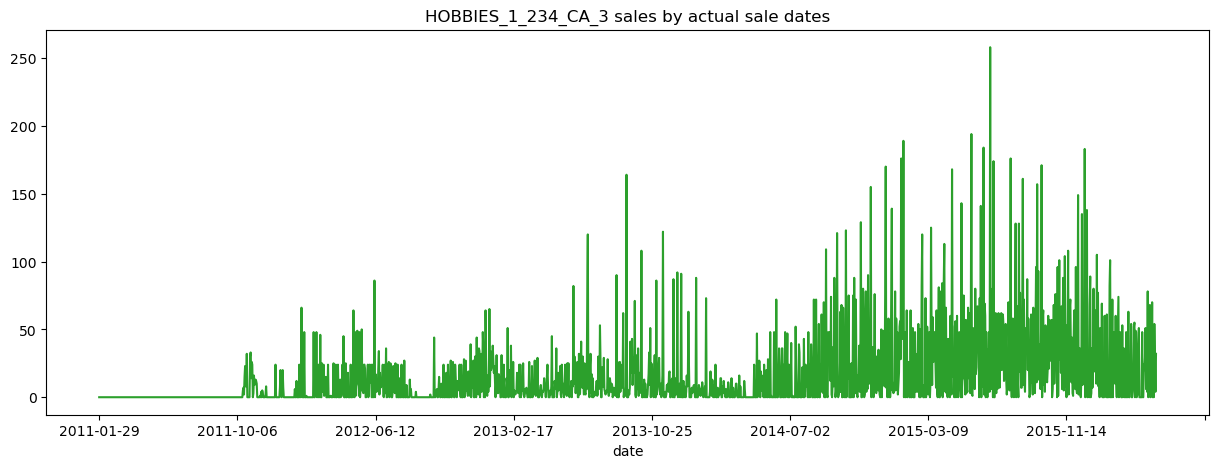

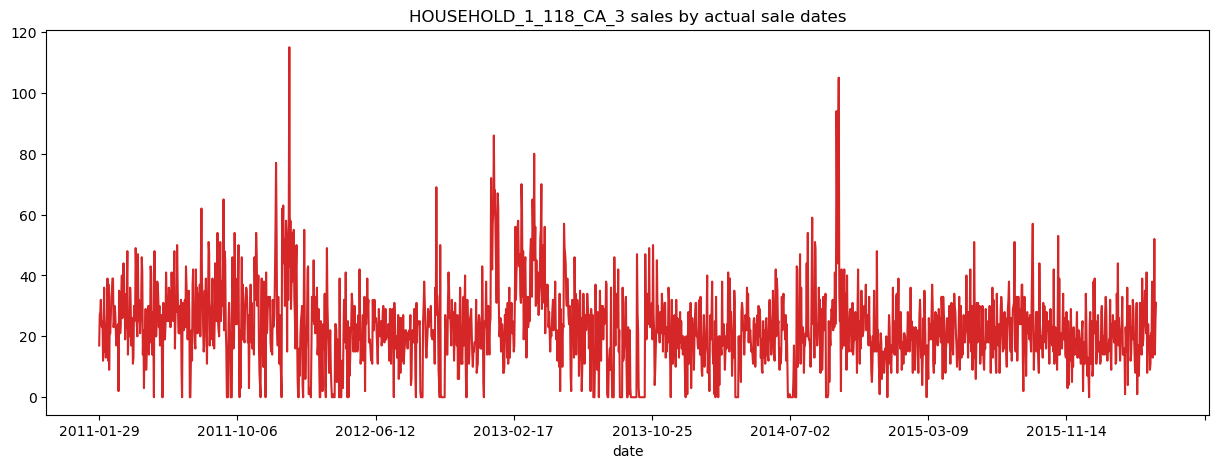

In [118]:
# Select more top selling examples
example2 = df.loc[df['id'] == 'HOBBIES_1_234_CA_3_validation'][dcols].T
example2 = example2.rename(columns={6324:'HOBBIES_1_234_CA_3'})
example2 = example2.reset_index().rename(columns={'index': 'd'}) 
example2 = example2.merge(calendar, how='left', validate='1:1')

example2.set_index('date')['HOBBIES_1_234_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOBBIES_1_234_CA_3 sales by actual sale dates')
plt.show()

example3 = df.loc[df['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][dcols].T
example3 = example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3'}) # Name it correctly
example3 = example3.reset_index().rename(columns={'index': 'd'}) # make the index "d"
example3 = example3.merge(calendar, how='left', validate='1:1')

example3.set_index('date')['HOUSEHOLD_1_118_CA_3'] \
    .plot(figsize=(15, 5),
          color=next(color_cycle),
          title='HOUSEHOLD_1_118_CA_3 sales by actual sale dates')
plt.show()


In [122]:
twenty_examples = df.sample(20, random_state = 529).set_index('id')[dcols].T.merge(
calendar.set_index('d')['date'], left_index = True, right_index = True, validate = '1:1').set_index('date')


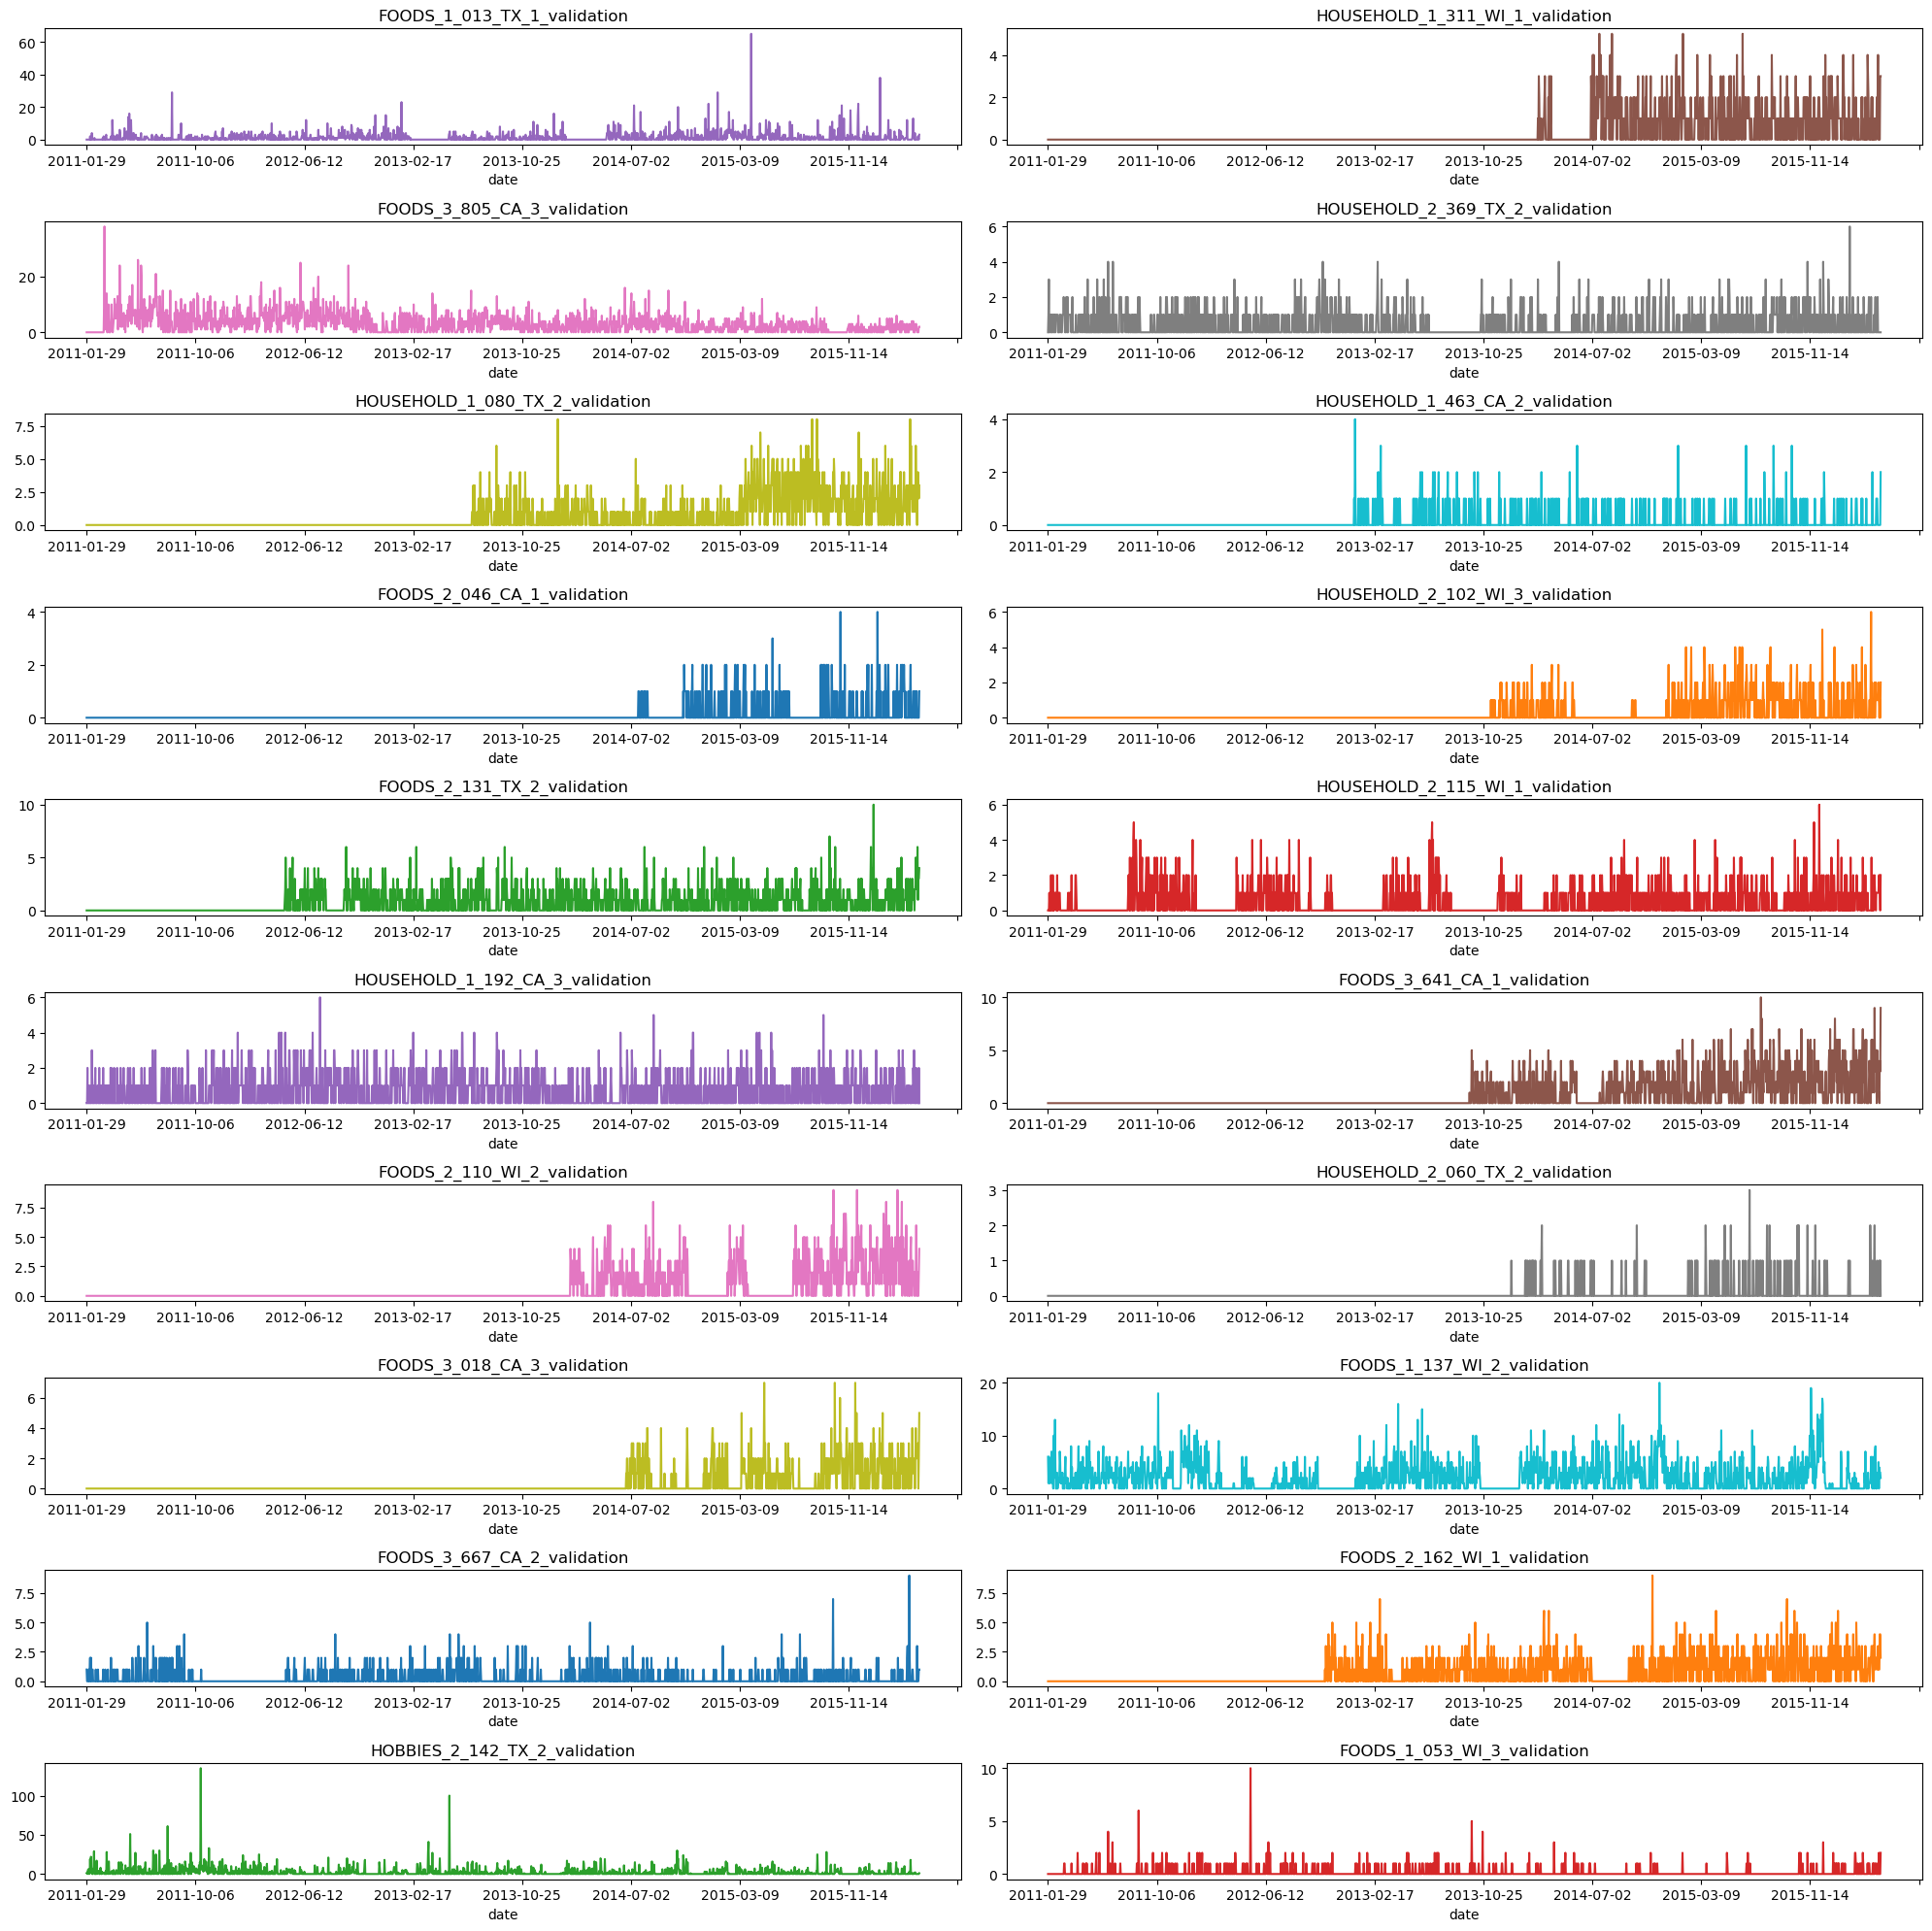

In [124]:
fig, axs = plt.subplots(10, 2, figsize = (20, 20))
axs = axs.flatten()

ax_idx = 0

for item in twenty_examples.columns:
    twenty_examples[item].plot(
    title = item, color = next(color_cycle),
    ax = axs[ax_idx])
    ax_idx += 1
plt.tight_layout()
plt.show()


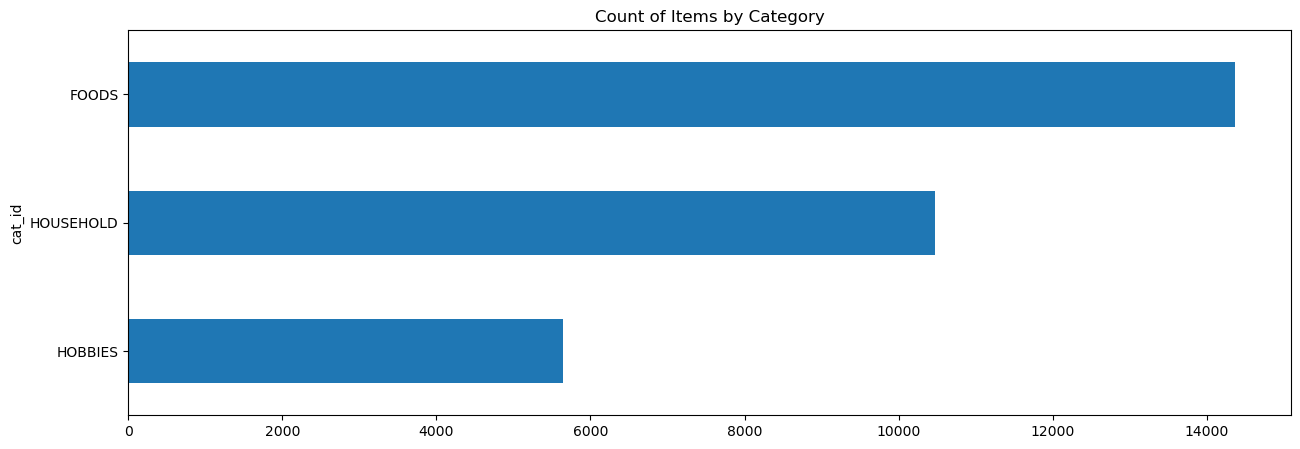

In [126]:
df.groupby('cat_id').count()['id'].sort_values().plot(kind = 'barh', figsize=(15, 5), title='Count of Items by Category')
plt.show()


In [128]:
past_sales = df.set_index('id')[dcols].T.merge(calendar.set_index('d')['date'], left_index = True, right_index = True, validate = '1:1').set_index('date')


In [130]:
past_sales.head(5)


HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_007_CA_1_validation  HOBBIES_1_008_CA_1_validation  \
date                                                                       
2011-01-29                              0                             12   
2011-01-30                              0                             15   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_009_CA_1_validation  HOBBIES_1_010_CA_1_validation  ...  \
date                                                                      ...   
2011-01-29                              2                              0  ...   
2011-01-30                              0                              0  ...   
2011-01-31                              7                              1  ...   
2011-02-01                              3                              0  ...   
2011-02-02                              0                              0  ...   

            FOODS_3_818_WI_3_validation  FOODS_3_819_WI_3_validation  \
date                                                                   
2011-01-29                            0                           14   
2011-01-30                            0                           11   
2011-01-31                            0                            5   
2011-02-01                            0                            6   
2011-02-02                            0                            5   

            FOODS_3_820_WI_3_validation  FOODS_3_821_WI_3_validation  \
date                                                                   
2011-01-29                            1                            0   
2011-01-30                            1                            0   
2011-01-31                            1                            0   
2011-02-01                            1                            0   
2011-02-02                            1                            0   

            FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
date                                                                   
2011-01-29                            4                            0   
2011-01-30                            4                            0   
2011-01-31    

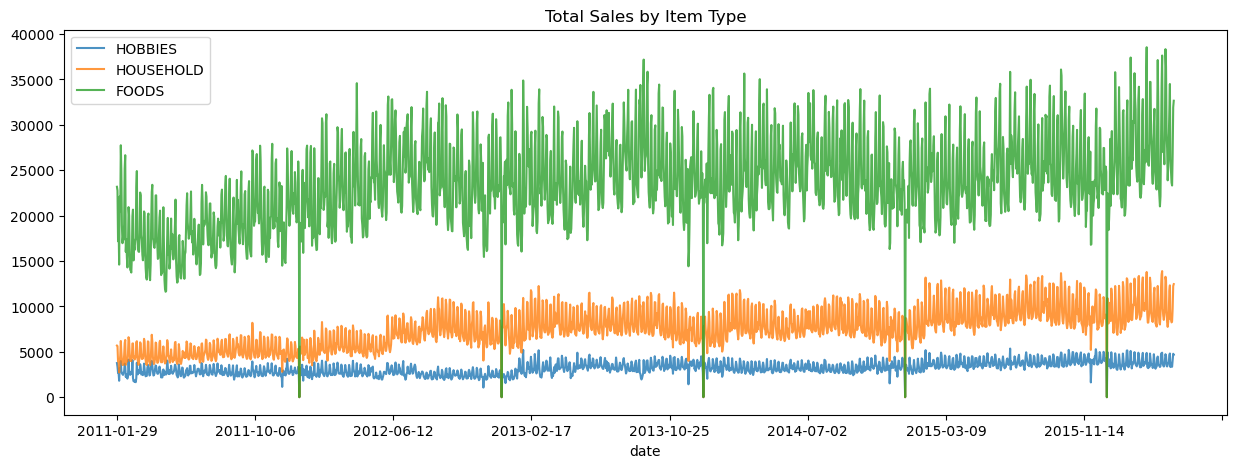

In [132]:
for i in df['cat_id'].unique():
    items_col = [c for c in past_sales.columns if i in c]
    past_sales[items_col].sum(axis = 1).plot(figsize = (15, 5), alpha = 0.8, title = 'Total Sales by Item Type')
plt.legend(df['cat_id'].unique())
plt.show()


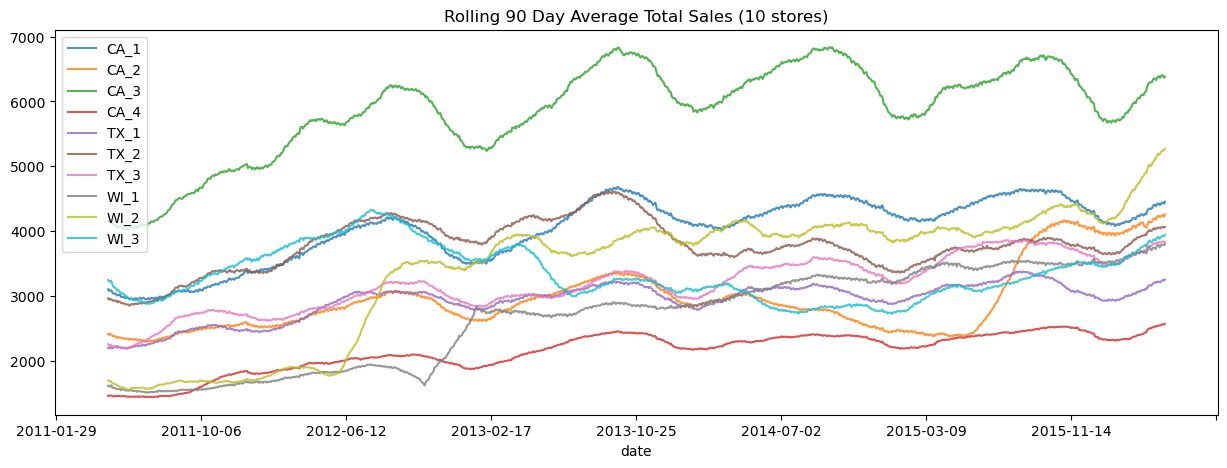

In [134]:
store_list = sell_prices['store_id'].unique()
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(90).mean() \
        .plot(figsize=(15, 5),
              alpha=0.8,
              title='Rolling 90 Day Average Total Sales (10 stores)')
plt.legend(store_list)
plt.show()
## Average sales of itmes in each store on 90 days average.


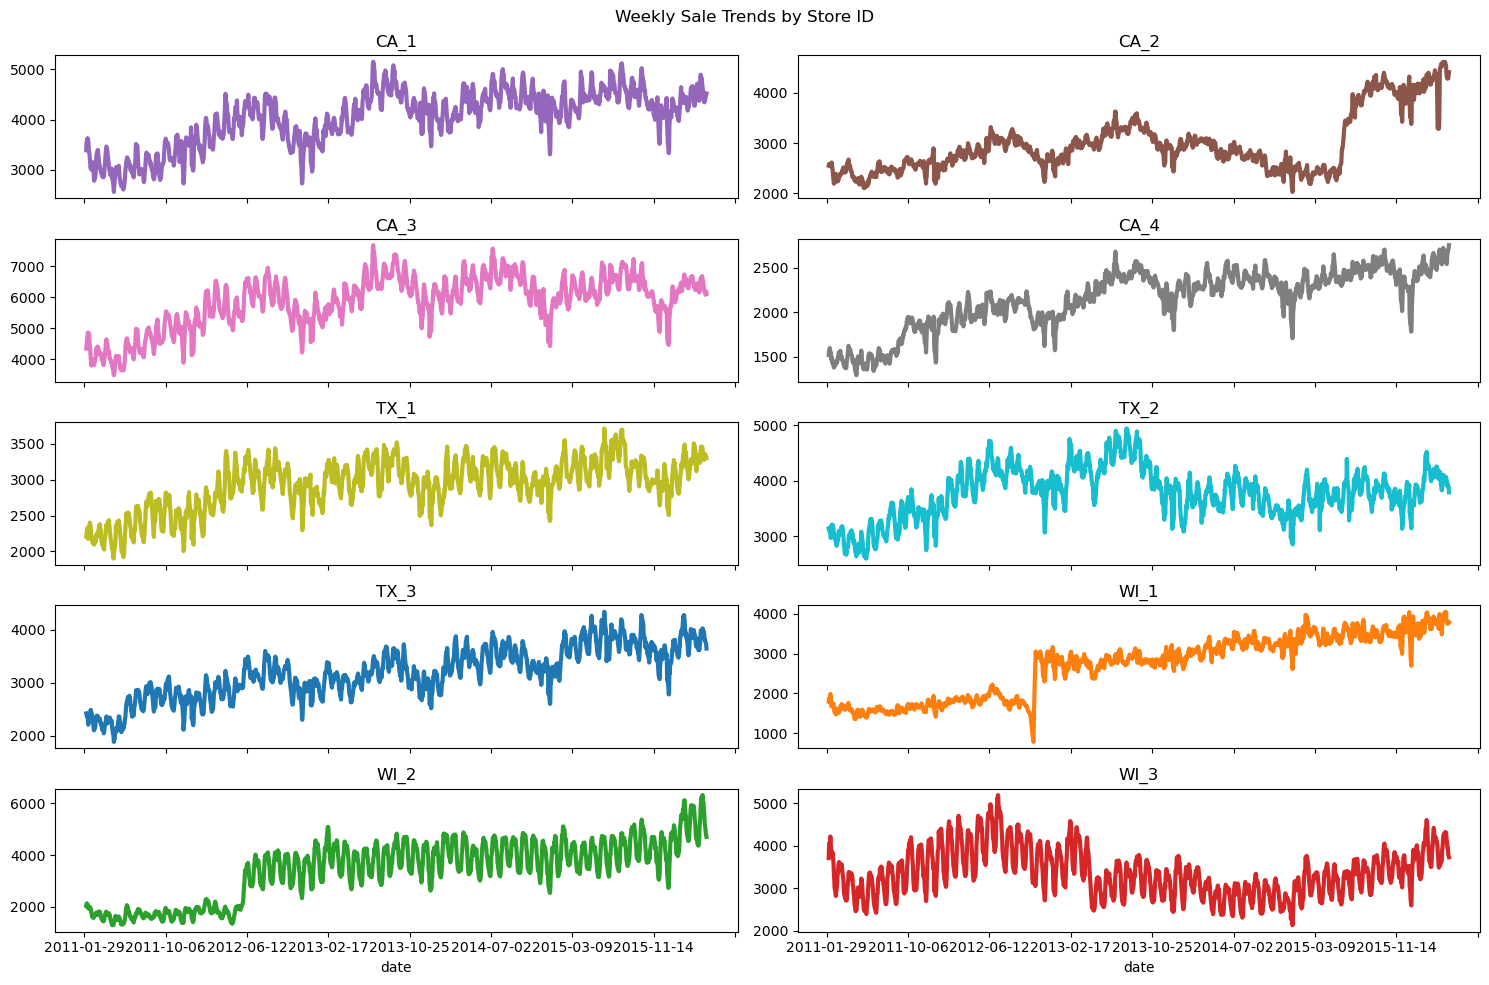

In [136]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
for s in store_list:
    store_items = [c for c in past_sales.columns if s in c]
    past_sales[store_items] \
        .sum(axis=1) \
        .rolling(7).mean() \
        .plot(alpha=1,
              ax=axes[ax_idx],
              title=s,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Weekly Sale Trends by Store ID')
plt.tight_layout()
plt.show()


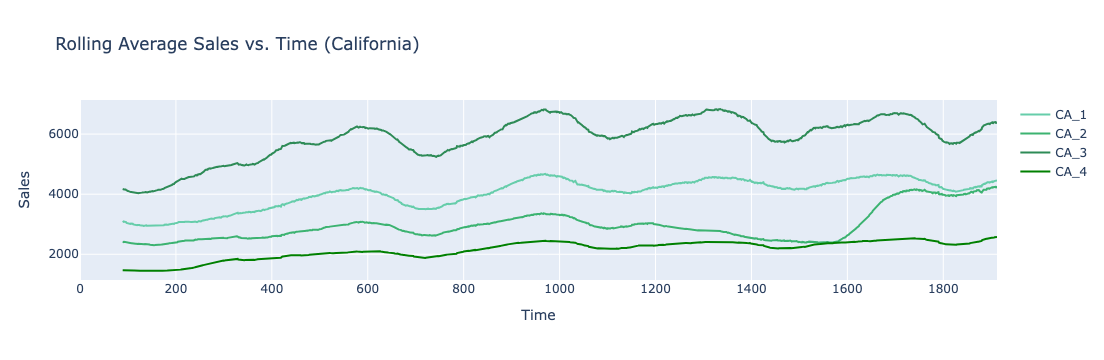

In [138]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

greens = ["mediumaquamarine", "mediumseagreen", "seagreen", "green"]
store_list = sell_prices['store_id'].unique()
fig = go.Figure()
means = [] ## Mean sale of each store across all duration.
stores = [] ## Unique Store ids
for i, s in enumerate(store_list):
    if "ca" in s or "CA" in s:
        store_items = [c for c in past_sales.columns if s in c]
        data = past_sales[store_items].sum(axis=1).rolling(90).mean() ## Rolling 90 days average
        means.append(np.mean(past_sales[store_items].sum(axis=1)))
        stores.append(s)
        fig.add_trace(go.Scatter(x=np.arange(len(data)), y=data, name=s, marker=dict(color=greens[i])))
fig.update_layout(yaxis_title="Sales", xaxis_title="Time", title="Rolling Average Sales vs. Time (California)")


In [140]:
calendar1 = calendar[['date', 'weekday', 'wday', 'month', 'year']]


In [142]:
calendar1.head()


date    weekday  wday  month  year
0  2011-01-29   Saturday     1      1  2011
1  2011-01-30     Sunday     2      1  2011
2  2011-01-31     Monday     3      1  2011
3  2011-02-01    Tuesday     4      2  2011
4  2011-02-02  Wednesday     5      2  2011

In [144]:
past_sales1 = past_sales.merge(calendar1.set_index('date'), left_index = True, right_index = True, validate = '1:1')


In [146]:
past_sales1.head()


HOBBIES_1_001_CA_1_validation  HOBBIES_1_002_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_003_CA_1_validation  HOBBIES_1_004_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_005_CA_1_validation  HOBBIES_1_006_CA_1_validation  \
date                                                                       
2011-01-29                              0                              0   
2011-01-30                              0                              0   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_007_CA_1_validation  HOBBIES_1_008_CA_1_validation  \
date                                                                       
2011-01-29                              0                             12   
2011-01-30                              0                             15   
2011-01-31                              0                              0   
2011-02-01                              0                              0   
2011-02-02                              0                              0   

            HOBBIES_1_009_CA_1_validation  HOBBIES_1_010_CA_1_validation  ...  \
date                                                                      ...   
2011-01-29                              2                              0  ...   
2011-01-30                              0                              0  ...   
2011-01-31                              7                              1  ...   
2011-02-01                              3                              0  ...   
2011-02-02                              0                              0  ...   

            FOODS_3_822_WI_3_validation  FOODS_3_823_WI_3_validation  \
date                                                                   
2011-01-29                            4                            0   
2011-01-30                            4                            0   
2011-01-31                            2                            2   
2011-02-01                            5                            2   
2011-02-02                            2                            0   

            FOODS_3_824_WI_3_validation  FOODS_3_825_WI_3_validation  \
date                                                                   
2011-01-29                            0                            0   
2011-01-30                            0                            6   
2011-01-31                            0                            0   
2011-02-01                            0                            2   
2011-02-02                            0                            2   

            FOODS_3_826_WI_3_validation  FOODS_3_827_WI_3_validation  \
date                                                                   
2011-01-29                            0                            0   
2011-01-30                            0                            0   
2011-01-31    

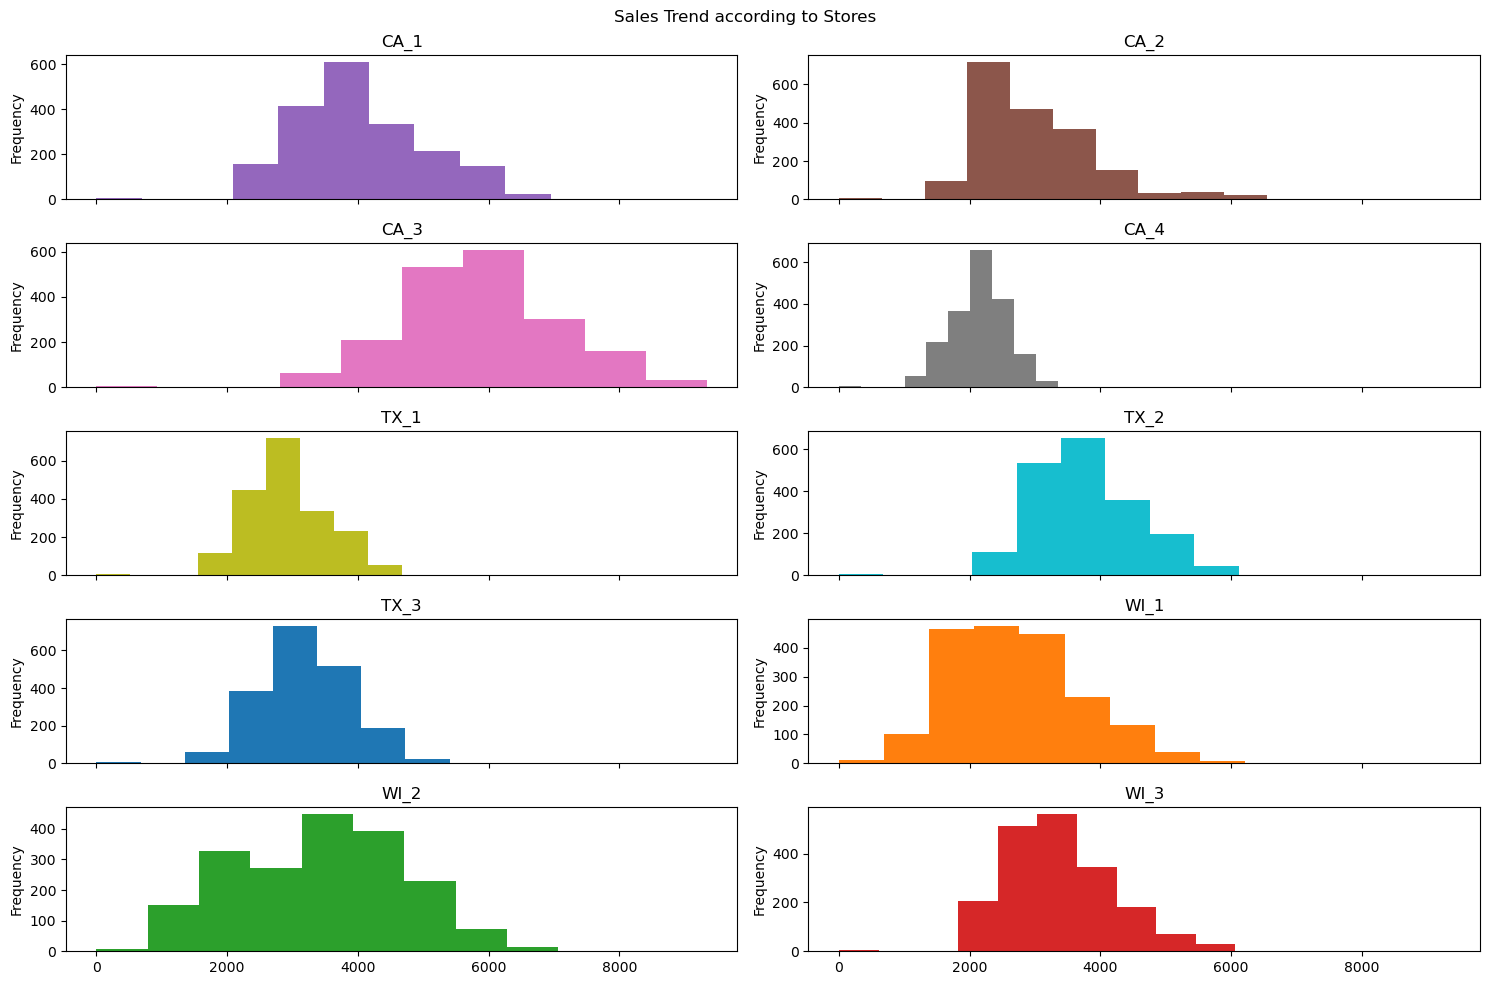

In [148]:
fig, axes = plt.subplots(5, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
stores = df['store_id'].unique()
for store in stores:
    store_items = [c for c in past_sales1.columns if store in c]
    past_sales1[store_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=store,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Stores')
plt.tight_layout()
plt.show()


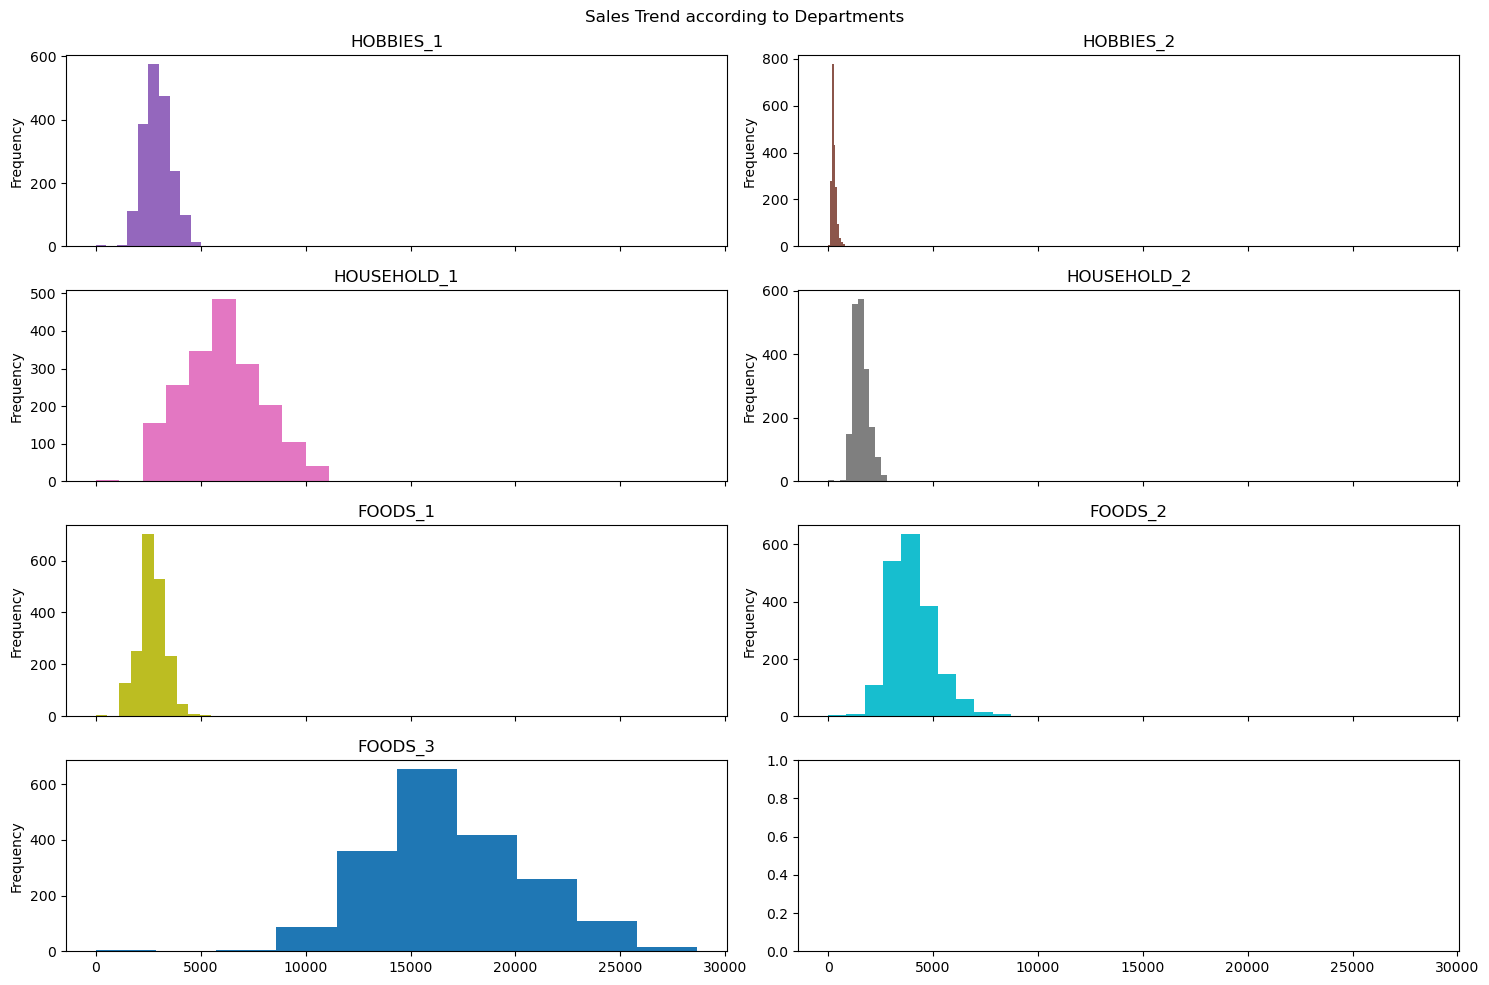

In [150]:
fig, axes = plt.subplots(4, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
depts = df['dept_id'].unique()
for dept in depts:
    dept_items = [c for c in past_sales1.columns if dept in c]
    past_sales1[dept_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=dept,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Departments')
plt.tight_layout()
plt.show()


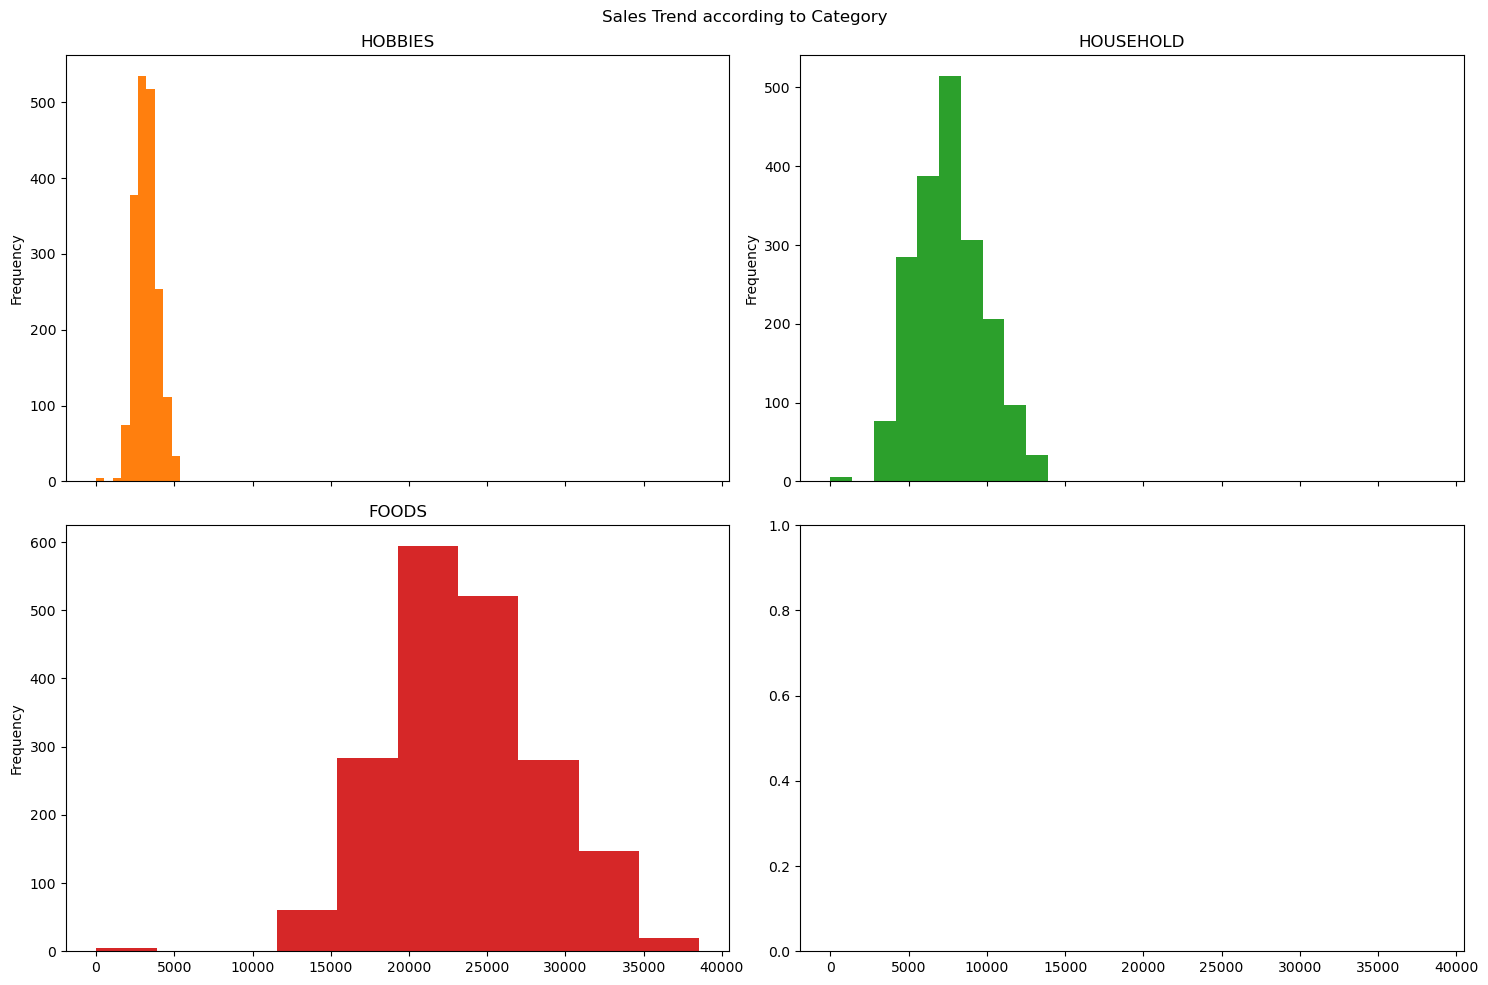

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
cats = df['cat_id'].unique()
for cat in cats:
    cat_items = [c for c in past_sales1.columns if cat in c]
    past_sales1[cat_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=cat,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1

plt.suptitle('Sales Trend according to Category')
plt.tight_layout()
plt.show()


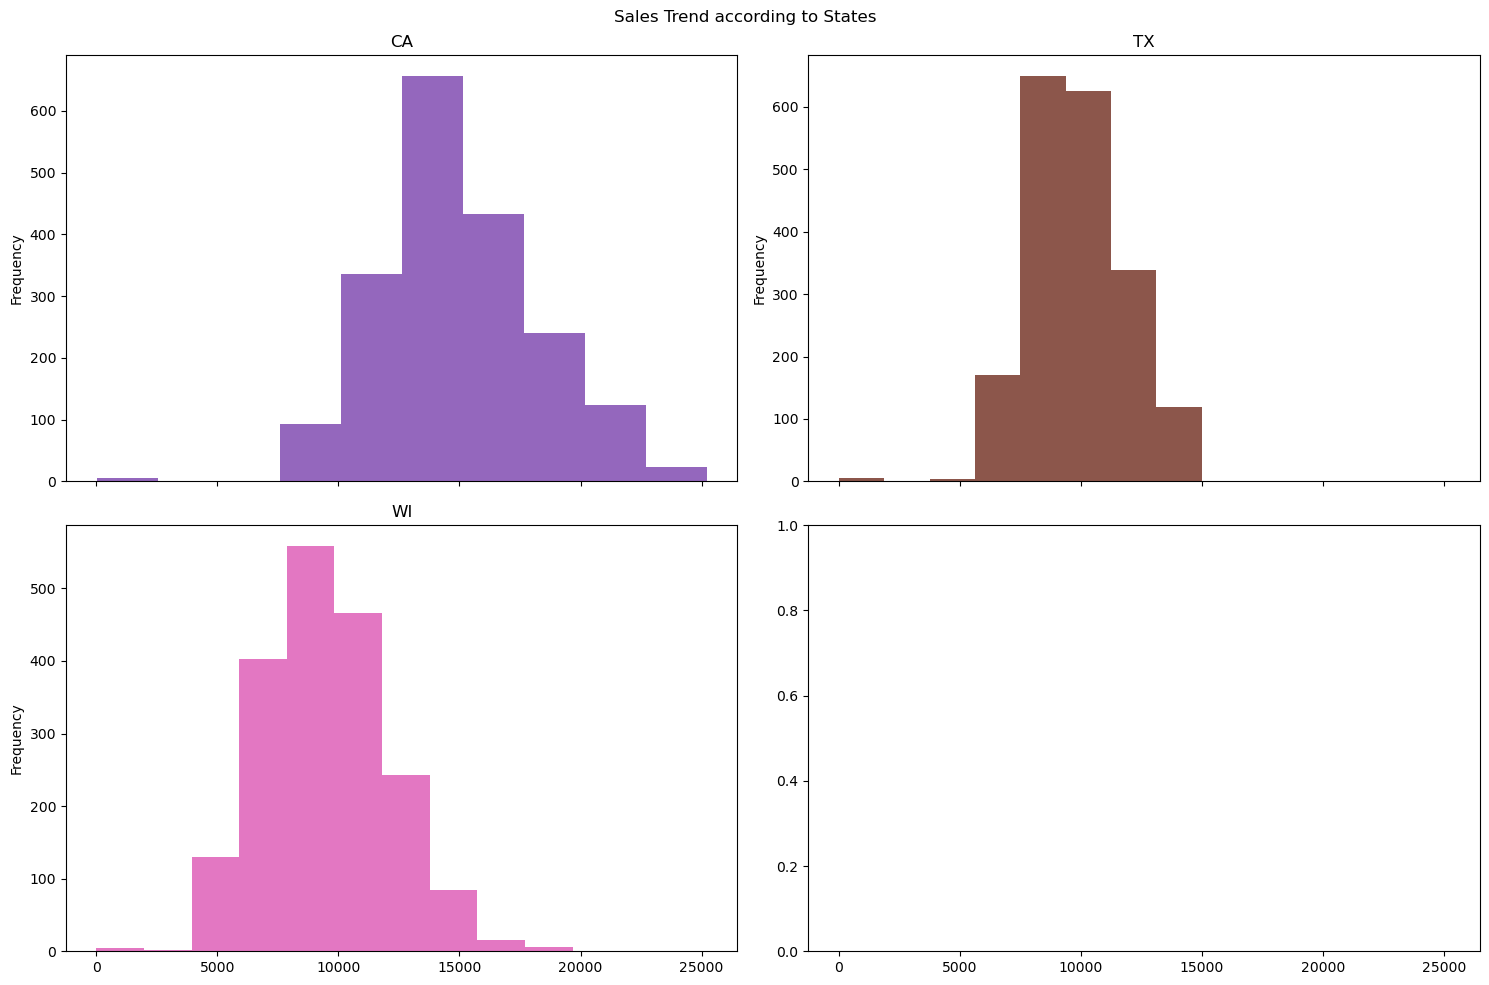

In [154]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
axes = axes.flatten()
ax_idx = 0
states = df['state_id'].unique()
for state in states:
    state_items = [c for c in past_sales1.columns if state in c]
    past_sales1[state_items] \
        .sum(axis=1) \
        .plot(alpha=1,
              kind = "hist",
              ax=axes[ax_idx],
              title=state,
              lw=3,
              color=next(color_cycle))
    ax_idx += 1
# plt.legend(store_list)
plt.suptitle('Sales Trend according to States')
plt.tight_layout()
plt.show()


In [156]:
salesSummer = past_sales1[(past_sales1['month'] == 6) | (past_sales1['month'] == 7) | (past_sales1['month'] == 8)]


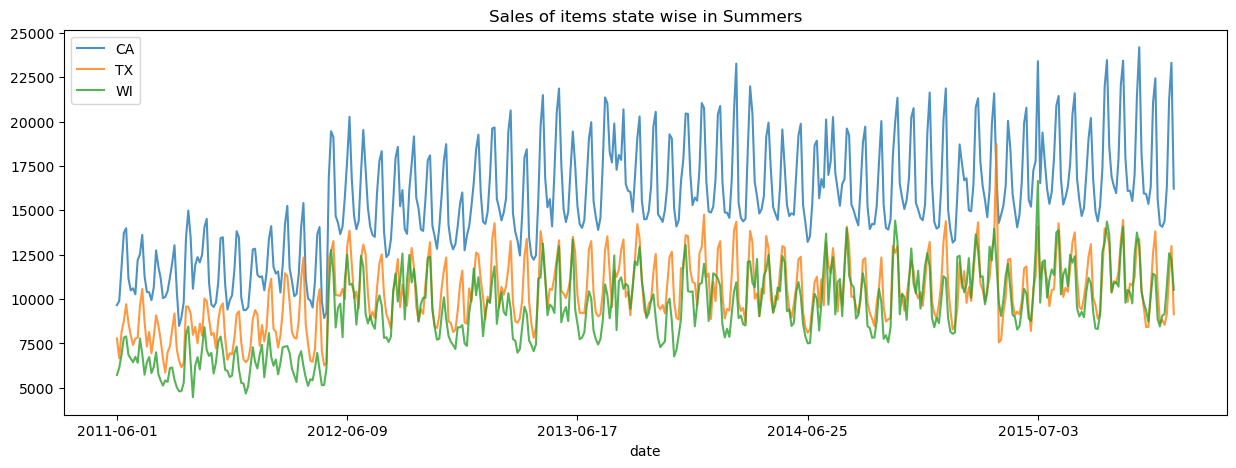

In [158]:
states = df['state_id'].unique()
for state in states:
    cols = [c for c in salesSummer.columns if state in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items state wise in Summers')
plt.legend(states)
plt.show()    


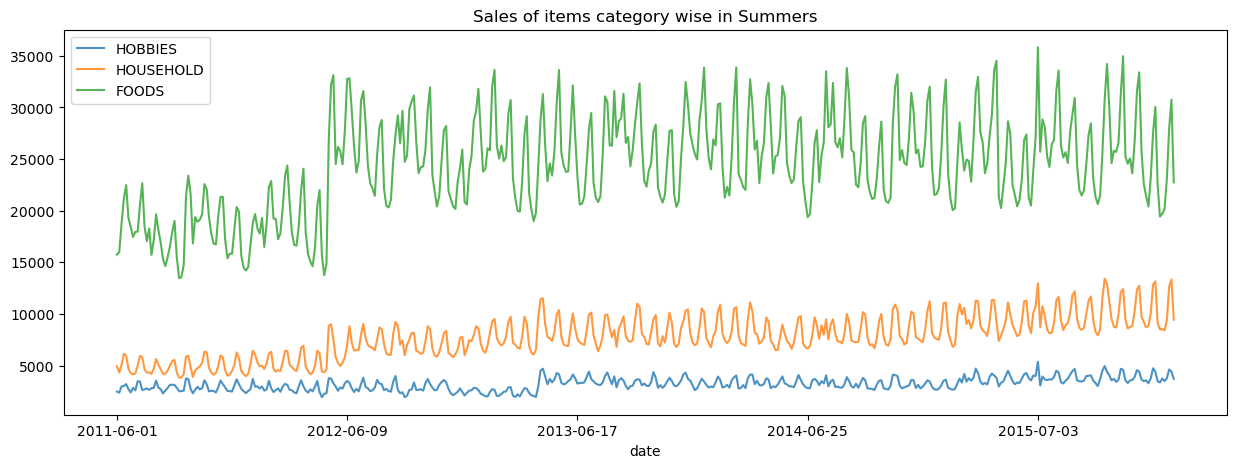

In [160]:
categories = df['cat_id'].unique()
for cat in categories:
    cols = [c for c in salesSummer.columns if cat in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items category wise in Summers')
plt.legend(categories)
plt.show()


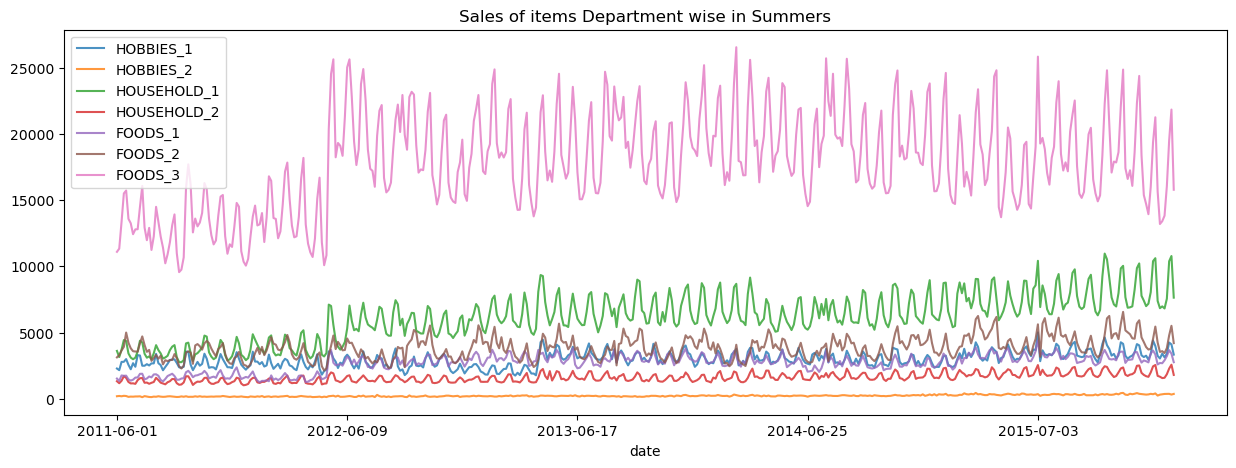

In [162]:
depts = df['dept_id'].unique()
for dept in depts:
    cols = [c for c in salesSummer.columns if dept in c]
    salesSummer[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items Department wise in Summers')
plt.legend(depts)
plt.show()


(array([17., 27., 41., 83., 73., 83., 50., 43., 31., 12.]),
 array([ 9560. , 11257.7, 12955.4, 14653.1, 16350.8, 18048.5, 19746.2,
        21443.9, 23141.6, 24839.3, 26537. ]),
 <BarContainer object of 10 artists>)

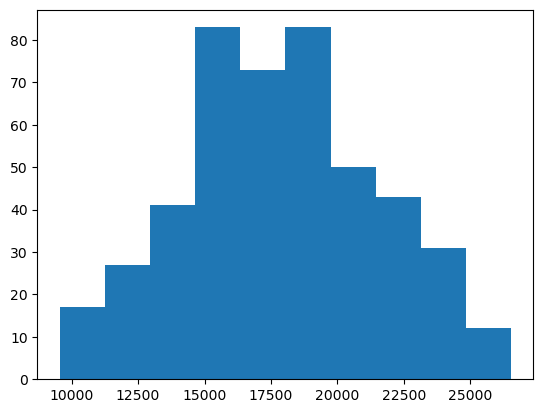

In [164]:
plt.hist(salesSummer[cols].sum(axis = 1))


In [166]:
salesChristmas = past_sales1[past_sales1['month'] == 12]


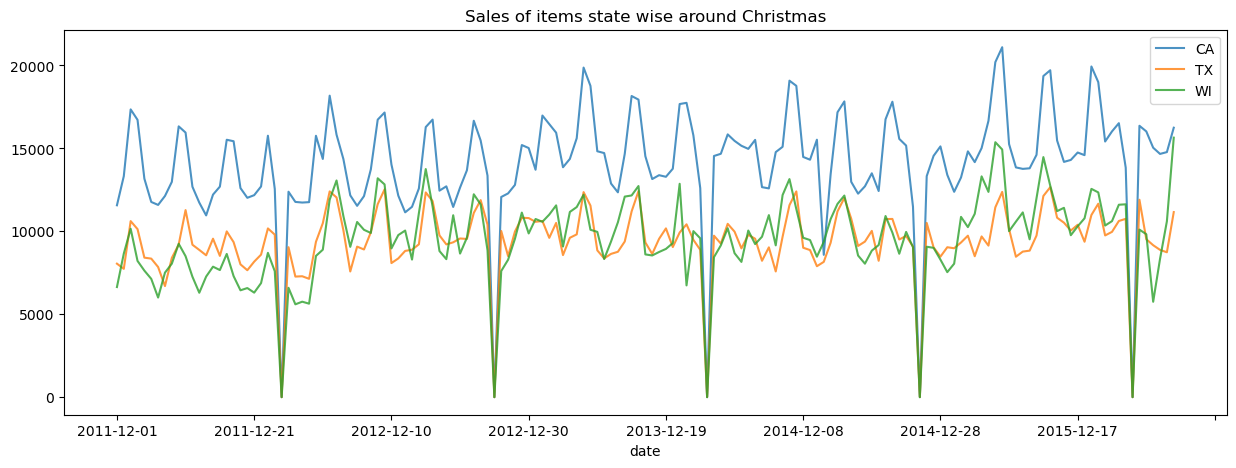

In [168]:
states = df['state_id'].unique()
for state in states:
    cols = [c for c in salesChristmas.columns if state in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items state wise around Christmas')
plt.legend(states)
plt.show()    


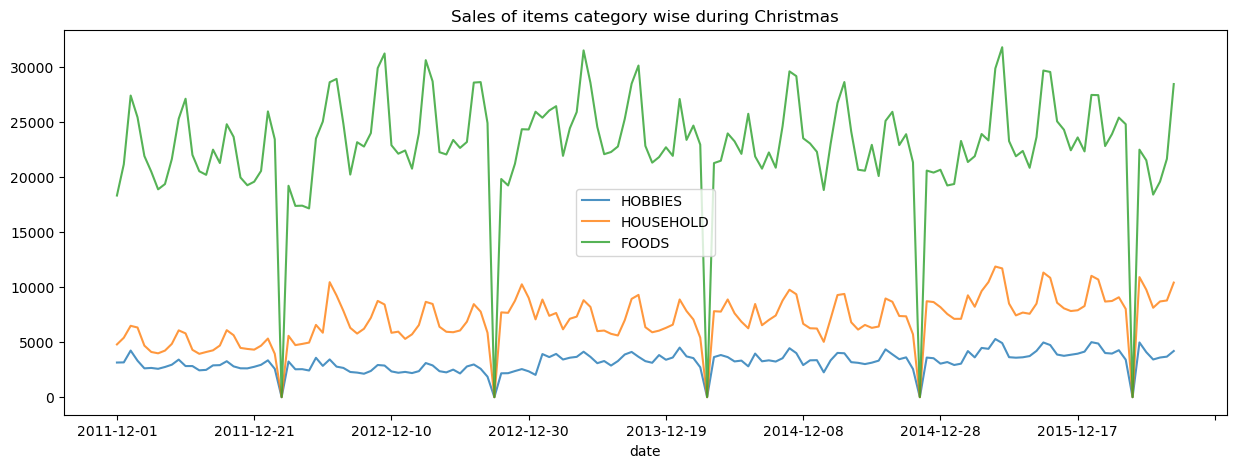

In [170]:
categories = df['cat_id'].unique()
for cat in categories:
    cols = [c for c in salesChristmas.columns if cat in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items category wise during Christmas')
plt.legend(categories)
plt.show()


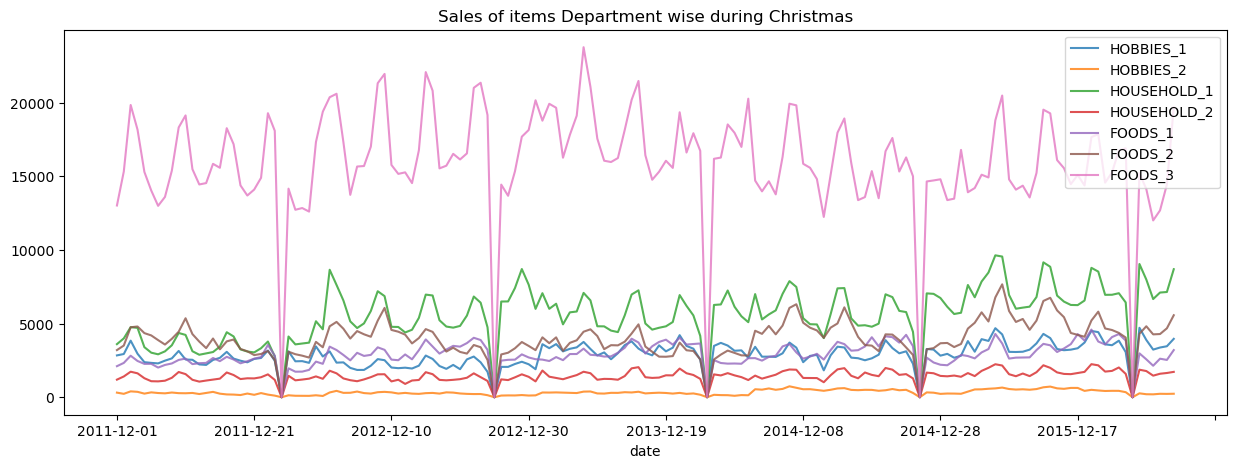

In [172]:
depts = df['dept_id'].unique()
for dept in depts:
    cols = [c for c in salesChristmas.columns if dept in c]
    salesChristmas[cols] \
        .sum(axis=1).plot(figsize=(15, 5),
              alpha=0.8,
              title='Sales of items Department wise during Christmas')
plt.legend(depts)
plt.show()


In [174]:
df['store_id'].unique() ## These are all the stores.


array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [176]:
df['dept_id'].unique() ## These are all the departments.


array(['HOBBIES_1', 'HOBBIES_2', 'HOUSEHOLD_1', 'HOUSEHOLD_2', 'FOODS_1',
       'FOODS_2', 'FOODS_3'], dtype=object)

In [178]:
stores = df['store_id'].unique()
depts = df['dept_id'].unique()
a = []
concat = []
for store in stores:
    for dept in depts:
        concat.append(store+'_'+dept)
        cols = [c for c in past_sales1 if store in c and dept in c]
        a.append(past_sales1[cols].sum(axis=1).values)


In [180]:
final = {}
for i in range(0, len(a)):
    final[concat[i]] = a[i]


In [182]:
final.keys()


dict_keys(['CA_1_HOBBIES_1', 'CA_1_HOBBIES_2', 'CA_1_HOUSEHOLD_1', 'CA_1_HOUSEHOLD_2', 'CA_1_FOODS_1', 'CA_1_FOODS_2', 'CA_1_FOODS_3', 'CA_2_HOBBIES_1', 'CA_2_HOBBIES_2', 'CA_2_HOUSEHOLD_1', 'CA_2_HOUSEHOLD_2', 'CA_2_FOODS_1', 'CA_2_FOODS_2', 'CA_2_FOODS_3', 'CA_3_HOBBIES_1', 'CA_3_HOBBIES_2', 'CA_3_HOUSEHOLD_1', 'CA_3_HOUSEHOLD_2', 'CA_3_FOODS_1', 'CA_3_FOODS_2', 'CA_3_FOODS_3', 'CA_4_HOBBIES_1', 'CA_4_HOBBIES_2', 'CA_4_HOUSEHOLD_1', 'CA_4_HOUSEHOLD_2', 'CA_4_FOODS_1', 'CA_4_FOODS_2', 'CA_4_FOODS_3', 'TX_1_HOBBIES_1', 'TX_1_HOBBIES_2', 'TX_1_HOUSEHOLD_1', 'TX_1_HOUSEHOLD_2', 'TX_1_FOODS_1', 'TX_1_FOODS_2', 'TX_1_FOODS_3', 'TX_2_HOBBIES_1', 'TX_2_HOBBIES_2', 'TX_2_HOUSEHOLD_1', 'TX_2_HOUSEHOLD_2', 'TX_2_FOODS_1', 'TX_2_FOODS_2', 'TX_2_FOODS_3', 'TX_3_HOBBIES_1', 'TX_3_HOBBIES_2', 'TX_3_HOUSEHOLD_1', 'TX_3_HOUSEHOLD_2', 'TX_3_FOODS_1', 'TX_3_FOODS_2', 'TX_3_FOODS_3', 'WI_1_HOBBIES_1', 'WI_1_HOBBIES_2', 'WI_1_HOUSEHOLD_1', 'WI_1_HOUSEHOLD_2', 'WI_1_FOODS_1', 'WI_1_FOODS_2', 'WI_1_FOODS_3

In [184]:
store_dept = pd.DataFrame(final)
store_dept.head()


CA_1_HOBBIES_1  CA_1_HOBBIES_2  CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  \
0             528              28               361               181   
1             489               9               350               170   
2             409               6               279               114   
3             383               9               278               123   
4             263               5               195               135   

   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_2_HOBBIES_1  CA_2_HOBBIES_2  \
0           297           674          2268             522              16   
1           284           655          2198             381              16   
2           214           396          1398             352              16   
3           175           476          1607             344               6   
4           182           354          1496             283              13   

   CA_2_HOUSEHOLD_1  ...  WI_2_FOODS_1  WI_2_FOODS_2  WI_2_FOODS_3  \
0               529  ...           191           155          1269   
1               461  ...           184           128          1121   
2               306  ...           154           199          1233   
3               270  ...           205           244          1564   
4               217  ...            96           147           724   

   WI_3_HOBBIES_1  WI_3_HOBBIES_2  WI_3_HOUSEHOLD_1  WI_3_HOUSEHOLD_2  \
0             256              22               584               148   
1             342              14               541               195   
2             228              20               420               106   
3             183              11               327                94   
4              70               4               151                53   

   WI_3_FOODS_1  WI_3_FOODS_2  WI_3_FOODS_3  
0           152           583          2293  
1           138           585          2383  
2           127           575          1841  
3            98           533          1965  
4            87           340          1427  

[5 rows x 70 columns]

In [186]:
store_dept['date'] = calendar['date']
store_dept['month'] = calendar['month']


In [188]:
store_dept.head()


CA_1_HOBBIES_1  CA_1_HOBBIES_2  CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  \
0             528              28               361               181   
1             489               9               350               170   
2             409               6               279               114   
3             383               9               278               123   
4             263               5               195               135   

   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_2_HOBBIES_1  CA_2_HOBBIES_2  \
0           297           674          2268             522              16   
1           284           655          2198             381              16   
2           214           396          1398             352              16   
3           175           476          1607             344               6   
4           182           354          1496             283              13   

   CA_2_HOUSEHOLD_1  ...  WI_2_FOODS_3  WI_3_HOBBIES_1  WI_3_HOBBIES_2  \
0               529  ...          1269             256              22   
1               461  ...          1121             342              14   
2               306  ...          1233             228              20   
3               270  ...          1564             183              11   
4               217  ...           724              70               4   

   WI_3_HOUSEHOLD_1  WI_3_HOUSEHOLD_2  WI_3_FOODS_1  WI_3_FOODS_2  \
0               584               148           152           583   
1               541               195           138           585   
2               420               106           127           575   
3               327                94            98           533   
4               151                53            87           340   

   WI_3_FOODS_3        date  month  
0          2293  2011-01-29      1  
1          2383  2011-01-30      1  
2          1841  2011-01-31      1  
3          1965  2011-02-01      2  
4          1427  2011-02-02      2  

[5 rows x 72 columns]

In [190]:
store_dept['date'] = pd.to_datetime(store_dept['date'])


In [192]:
month_level = pd.DataFrame()


In [194]:
store_dept.head()


CA_1_HOBBIES_1  CA_1_HOBBIES_2  CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  \
0             528              28               361               181   
1             489               9               350               170   
2             409               6               279               114   
3             383               9               278               123   
4             263               5               195               135   

   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_2_HOBBIES_1  CA_2_HOBBIES_2  \
0           297           674          2268             522              16   
1           284           655          2198             381              16   
2           214           396          1398             352              16   
3           175           476          1607             344               6   
4           182           354          1496             283              13   

   CA_2_HOUSEHOLD_1  ...  WI_2_FOODS_3  WI_3_HOBBIES_1  WI_3_HOBBIES_2  \
0               529  ...          1269             256              22   
1               461  ...          1121             342              14   
2               306  ...          1233             228              20   
3               270  ...          1564             183              11   
4               217  ...           724              70               4   

   WI_3_HOUSEHOLD_1  WI_3_HOUSEHOLD_2  WI_3_FOODS_1  WI_3_FOODS_2  \
0               584               148           152           583   
1               541               195           138           585   
2               420               106           127           575   
3               327                94            98           533   
4               151                53            87           340   

   WI_3_FOODS_3       date  month  
0          2293 2011-01-29      1  
1          2383 2011-01-30      1  
2          1841 2011-01-31      1  
3          1965 2011-02-01      2  
4          1427 2011-02-02      2  

[5 rows x 72 columns]

In [196]:
def store_cat_month(month_level):
    for col in store_dept.drop(['date', 'month'], axis = 1).columns:
        month_level[col] = store_dept.resample('M', on='date')[col].sum().values
    return month_level


In [198]:
month_level = store_cat_month(month_level)


/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/var/folders/h3/lplmwndn2l1cw5q526nm0rlh0000gn/T/ipykernel_9566/308219661.py:3: FutureWarning:


In [200]:
month_level = month_level.reset_index()


In [202]:
month_level.rename(columns = {'index': 'Month_'}, inplace = True)
month_level['Month_'] += 1
month_level.head()


Month_  CA_1_HOBBIES_1  CA_1_HOBBIES_2  CA_1_HOUSEHOLD_1  CA_1_HOUSEHOLD_2  \
0       1            1426              43               990               465   
1       2           11855             357              8213              3886   
2       3           12066             616              9076              4413   
3       4           12655             625             10035              4623   
4       5           12261             696              9316              4631   

   CA_1_FOODS_1  CA_1_FOODS_2  CA_1_FOODS_3  CA_2_HOBBIES_1  CA_2_HOBBIES_2  \
0           795          1725          5864            1255              48   
1          6595         12962         45566            9499             499   
2          6952         13050         47295           10898             631   
3          5507         12589         45519           10490             630   
4          5569         13250         42265           10013             704   

   ...  WI_2_FOODS_1  WI_2_FOODS_2  WI_2_FOODS_3  WI_3_HOBBIES_1  \
0  ...           529           482          3623             826   
1  ...          4810          5727         28016            6679   
2  ...          4868          5861         25897            7265   
3  ...          4040          5178         24396            7621   
4  ...          3580          4988         23098            7331   

   WI_3_HOBBIES_2  WI_3_HOUSEHOLD_1  WI_3_HOUSEHOLD_2  WI_3_FOODS_1  \
0              56              1545               449           417   
1             379             11494              3380          3863   
2             622             13448              3224          4036   
3             645             12363              3154          4326   
4             616             11271              3493          4375   

   WI_3_FOODS_2  WI_3_FOODS_3  
0          1743          6517  
1         16451         55713  
2         15525         53747  
3         14716         48654  
4         13735         44799  

[5 rows x 71 columns]

In [204]:
month_level.shape


(64, 71)

In [206]:
month_level = month_level.T


In [208]:
month_level.head()


0      1      2      3      4      5      6      7   \
Month_               1      2      3      4      5      6      7      8   
CA_1_HOBBIES_1    1426  11855  12066  12655  12261  12263  12441  12537   
CA_1_HOBBIES_2      43    357    616    625    696    645    484    412   
CA_1_HOUSEHOLD_1   990   8213   9076  10035   9316   9880  10958  11618   
CA_1_HOUSEHOLD_2   465   3886   4413   4623   4631   4755   5009   4674   

                     8      9   ...     54     55     56     57     58     59  \
Month_                9     10  ...     55     56     57     58     59     60   
CA_1_HOBBIES_1    12372  13140  ...  16250  16676  15004  15563  15224  16175   
CA_1_HOBBIES_2      352    680  ...   1241   1257   1048   1809   1457   1406   
CA_1_HOUSEHOLD_1  11263  12062  ...  25135  26828  24489  25501  23305  22580   
CA_1_HOUSEHOLD_2   4267   4373  ...   7187   7055   6176   6624   5564   5936   

                     60     61     62     63  
Month_               61     62     63     64  
CA_1_HOBBIES_1    15292  14121  14473  12115  
CA_1_HOBBIES_2     1094   1156   1289    904  
CA_1_HOUSEHOLD_1  24563  22683  23643  19420  
CA_1_HOUSEHOLD_2   5682   5803   6395   5487  

[5 rows x 64 columns]

In [210]:
df.columns = df.iloc[0]
month_level.columns = month_level.iloc[0]
month_level.drop(month_level.index[0], inplace = True)


In [212]:
month_level.head()


Month_              1      2      3      4      5      6      7      8   \
CA_1_HOBBIES_1    1426  11855  12066  12655  12261  12263  12441  12537   
CA_1_HOBBIES_2      43    357    616    625    696    645    484    412   
CA_1_HOUSEHOLD_1   990   8213   9076  10035   9316   9880  10958  11618   
CA_1_HOUSEHOLD_2   465   3886   4413   4623   4631   4755   5009   4674   
CA_1_FOODS_1       795   6595   6952   5507   5569   6281   6726   5785   

Month_               9      10  ...     55     56     57     58     59     60  \
CA_1_HOBBIES_1    12372  13140  ...  16250  16676  15004  15563  15224  16175   
CA_1_HOBBIES_2      352    680  ...   1241   1257   1048   1809   1457   1406   
CA_1_HOUSEHOLD_1  11263  12062  ...  25135  26828  24489  25501  23305  22580   
CA_1_HOUSEHOLD_2   4267   4373  ...   7187   7055   6176   6624   5564   5936   
CA_1_FOODS_1       5590   6571  ...  12007  10666   9074   9049   6944  10596   

Month_               61     62     63     64  
CA_1_HOBBIES_1    15292  14121  14473  12115  
CA_1_HOBBIES_2     1094   1156   1289    904  
CA_1_HOUSEHOLD_1  24563  22683  23643  19420  
CA_1_HOUSEHOLD_2   5682   5803   6395   5487  
CA_1_FOODS_1       9101   9186  10148   7030  

[5 rows x 64 columns]

In [214]:
month_level.drop([1], axis = 1, inplace = True)


In [216]:
month_level


Month_               2      3      4      5      6      7      8      9   \
CA_1_HOBBIES_1    11855  12066  12655  12261  12263  12441  12537  12372   
CA_1_HOBBIES_2      357    616    625    696    645    484    412    352   
CA_1_HOUSEHOLD_1   8213   9076  10035   9316   9880  10958  11618  11263   
CA_1_HOUSEHOLD_2   3886   4413   4623   4631   4755   5009   4674   4267   
CA_1_FOODS_1       6595   6952   5507   5569   6281   6726   5785   5590   
...                 ...    ...    ...    ...    ...    ...    ...    ...   
WI_3_HOUSEHOLD_1  11494  13448  12363  11271  12068  12338  12466  13542   
WI_3_HOUSEHOLD_2   3380   3224   3154   3493   3304   3428   3292   3225   
WI_3_FOODS_1       3863   4036   4326   4375   3762   4243   4054   4760   
WI_3_FOODS_2      16451  15525  14716  13735  14472  14244  15336  16720   
WI_3_FOODS_3      55713  53747  48654  44799  45931  55800  55311  53369   

Month_               10     11  ...     55     56     57     58     59     60  \
CA_1_HOBBIES_1    13140  11036  ...  16250  16676  15004  15563  15224  16175   
CA_1_HOBBIES_2      680    403  ...   1241   1257   1048   1809   1457   1406   
CA_1_HOUSEHOLD_1  12062  10594  ...  25135  26828  24489  25501  23305  22580   
CA_1_HOUSEHOLD_2   4373   4137  ...   7187   7055   6176   6624   5564   5936   
CA_1_FOODS_1       6571   5701  ...  12007  10666   9074   9049   6944  10596   
...                 ...    ...  ...    ...    ...    ...    ...    ...    ...   
WI_3_HOUSEHOLD_1  14430  12655  ...  19969  18987  18832  20306  18431  18343   
WI_3_HOUSEHOLD_2   3380   3153  ...   4040   4255   3131   3448   3515   3876   
WI_3_FOODS_1       4919   5071  ...   8445   7514   7289   7481   7387   8962   
WI_3_FOODS_2      16831  16424  ...  10960  11827  11647  15626  14779  14782   
WI_3_FOODS_3      63189  58858  ...  53189  51662  54591  56538  52343  49757   

Month_               61     62     63     64  
CA_1_HOBBIES_1    15292  14121  14473  12115  
CA_1_HOBBIES_2     1094   1156   1289    904  
CA_1_HOUSEHOLD_1  24563  22683  23643  19420  
CA_1_HOUSEHOLD_2   5682   5803   6395   5487  
CA_1_FOODS_1       9101   9186  10148   7030  
...                 ...    ...    ...    ...  
WI_3_HOUSEHOLD_1  18897  19697  20043  16420  
WI_3_HOUSEHOLD_2   4101   4585   4710   4020  
WI_3_FOODS_1       8753   8318   7920   5814  
WI_3_FOODS_2      16221  15832  17219  15048  
WI_3_FOODS_3      57235  59297  61882  51337  

[70 rows x 63 columns]